# Imports

In [1]:
%reload_ext nb_black
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly
import seaborn as sns

%matplotlib inline

plt.style.use(["dark_background"])
# %matplotlib ipympl

from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from category_encoders import LeaveOneOutEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
from functions_pkg import print_vif, predictions_df
from sklearn.metrics import (
    plot_confusion_matrix,
    plot_roc_curve,
    plot_precision_recall_curve,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
)
from sklearn.calibration import calibration_curve

<IPython.core.display.Javascript object>

* Categorical or continuous
* 10,000+ samples
* 20+ features

age = days (int)

In [2]:
path = "cardiovascular_disease_prediction/cardio_train.csv"
df = pd.read_csv(path, sep=";", index_col="id")

<IPython.core.display.Javascript object>

In [3]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


<IPython.core.display.Javascript object>

In [4]:
df.columns

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

<IPython.core.display.Javascript object>

In [5]:
# column renaming
mapping = {
    "ap_hi": "bp_hi",
    "ap_lo": "bp_lo",
    "gluc": "glucose",
    "alco": "alcohol",
    "cardio": "disease",
}

df = df.rename(columns=mapping)

<IPython.core.display.Javascript object>

In [6]:
df.disease.value_counts()

0    35021
1    34979
Name: disease, dtype: int64

<IPython.core.display.Javascript object>

In [7]:
df.isna().mean().sort_values(ascending=False)

disease        0.0
active         0.0
alcohol        0.0
smoke          0.0
glucose        0.0
cholesterol    0.0
bp_lo          0.0
bp_hi          0.0
weight         0.0
height         0.0
gender         0.0
age            0.0
dtype: float64

<IPython.core.display.Javascript object>

# Data Cleaning

In [8]:
# change gender to 0-1 binary
df.loc[:, "gender"] = df.gender - 1

<IPython.core.display.Javascript object>

In [9]:
# reduce interval in cholesterol & glucose from 1-3 to 0-2
df.loc[:, "cholesterol"] = df.cholesterol - 1
df.loc[:, "glucose"] = df.glucose - 1

<IPython.core.display.Javascript object>

In [10]:
df["yrs"] = df.age / 365
df["height_in"] = df.height / 2.54
df["height_ft"] = df.height / 30.48

<IPython.core.display.Javascript object>

# Exploration

In [11]:
num_cols = ["age", "bp_hi", "bp_lo", "bp_diff", "bmi"]


<IPython.core.display.Javascript object>

In [12]:
# blood pressure difference column
df["bp_diff"] = df.bp_hi - df.bp_lo

# BMI column to replace height and weight
# bmi = weight (kgs) / (height (m))^2
df["bmi"] = df.weight / (df.height / 100) ** 2

<IPython.core.display.Javascript object>

## Data errors

### BP value errors

In [13]:
# changing the value of the negative bp_lo samples to absolute value
df.loc[df.bp_lo < 0, "bp_lo"] = abs(df.loc[df.bp_lo < 0, "bp_lo"])

<IPython.core.display.Javascript object>

In [14]:
# samples with bp_hi < 0 ~ entry error with negative val
df.loc[df.bp_hi < 0, "bp_hi"] = abs(df.loc[df.bp_hi < 0, "bp_hi"])

<IPython.core.display.Javascript object>

In [15]:
# correcting sample bp_hi vals
df.loc[df.bp_hi == 902, "bp_hi"] = 90
df.loc[df.bp_hi == 906, "bp_lo"] = 60
df.loc[df.bp_hi == 906, "bp_hi"] = 90
df.loc[df.bp_hi == 909, "bp_hi"] = 90

<IPython.core.display.Javascript object>

In [16]:
# correcting sample bp_hi and bp_lo errors
df.loc[df.bp_hi == 907, "bp_lo"] = 70
df.loc[df.bp_hi == 907, "bp_hi"] = 90
df.loc[df.bp_hi == 806, "bp_lo"] = 60
df.loc[df.bp_hi == 806, "bp_hi"] = 80
df.loc[df.bp_hi == 960, "bp_hi"] = 90

<IPython.core.display.Javascript object>

In [17]:
# correcting sample bp_hi vals over 1000
df.loc[df.bp_hi > 1000, "bp_hi"] = (df[df.bp_hi > 1000].bp_hi) / 10

# correcting sample bp_hi vals over 10,000
df.loc[df.bp_hi > 1000, "bp_hi"] = (df[df.bp_hi > 1000].bp_hi) / 10

<IPython.core.display.Javascript object>

In [18]:
df.loc[df.bp_hi < 20, "bp_hi"] = (df[df.bp_hi < 20].bp_hi) * 10

<IPython.core.display.Javascript object>

In [19]:
df[df.bp_diff < 0].count()[1]

1234

<IPython.core.display.Javascript object>

> there are 1234 samples with a negative bp_diff; data entry error

In [20]:
# 963 samples with bp_lo > 400
df[df.bp_lo > 400].count()[1]

953

<IPython.core.display.Javascript object>

In [21]:
# correcting sample bp_lo vals over 500+
df.loc[df.bp_lo > 500, "bp_lo"] = (df[df.bp_lo > 500].bp_lo) / 10

df.loc[df.bp_lo > 500, "bp_lo"] = (df[df.bp_lo > 500].bp_lo) / 10


<IPython.core.display.Javascript object>

In [22]:
# count of blood pressure differences below 0
df[df.bp_diff < 0].count()[1]

1234

<IPython.core.display.Javascript object>

In [23]:
# fixing bp_hi value errors most likely due to a 1 being dropped from the beginning
df.loc[((df.bp_diff < 0) & (df.bp_hi < 100)), "bp_hi"] = (
    df[(df.bp_diff < 0) & (df.bp_hi < 100)].bp_hi
) + 100

<IPython.core.display.Javascript object>

In [24]:
hi_vals = df.loc[df.bp_diff < 0, "bp_hi"].copy()
lo_vals = df.loc[df.bp_diff < 0, "bp_lo"].copy()

df.loc[df.bp_diff < 0, "bp_hi"] = lo_vals
df.loc[df.bp_diff < 0, "bp_lo"] = hi_vals

<IPython.core.display.Javascript object>

In [25]:
# df.loc[df.bp_diff > 250, "bp_hi"]
df.loc[df.bp_lo == 10, "bp_lo"] = 100

<IPython.core.display.Javascript object>

In [26]:
# fixing data error at index 57646
df.loc[df.bp_hi == 309, "bp_lo"] = 90
df.loc[df.bp_hi == 309, "bp_hi"] = 130

<IPython.core.display.Javascript object>

In [27]:
# fixing data error at index 82269
df.loc[[82269], "bp_lo"] = 120

<IPython.core.display.Javascript object>

In [28]:
# there are still bp_lo vals = 0
df.bp_lo.describe()

count    70000.000000
mean        82.522857
std         13.681051
min          0.000000
25%         80.000000
50%         80.000000
75%         90.000000
max        220.000000
Name: bp_lo, dtype: float64

<IPython.core.display.Javascript object>

In [29]:
drop_idx = []
drop_idx.append(df[(df.bmi > 100) & (df.height < 80)].index)
drop_idx.append(df[(df.bp_lo == 0) & (df.bp_hi % 10 != 0)].index)
idx = df[(df.bp_lo == 0) & (df.bp_hi % 10 != 0)].index
df = df.drop(index=idx)

<IPython.core.display.Javascript object>

In [30]:
idx = df[df.bp_lo == 0].index
df = df.drop(index=idx)

<IPython.core.display.Javascript object>

In [31]:
# fixing bp_lo vals below 10
idx = df[df.bp_lo < 10].index

df.loc[idx, "bp_lo"] = df.loc[idx].bp_lo * 10

<IPython.core.display.Javascript object>

In [32]:
# drop all samples with bp_lo <=30
# df[df.bp_lo <= 30]
idx = df[df.bp_lo <= 30].index
df = df.drop(index=idx)

<IPython.core.display.Javascript object>

In [33]:
idx1 = df[df.bp_hi > 400].index[0]
idx2 = df[df.bp_hi > 400].index[1]

df.loc[idx1, "bp_hi"] = 170
df.loc[idx2, "bp_hi"] = 140

<IPython.core.display.Javascript object>

In [34]:
# 1043 samples have the bp_hi and bp_lo values swapped
idx = df[df.bp_diff < 0].index
# type(idx)
bp_hi = df.loc[idx, "bp_hi"].copy()
bp_lo = df.loc[idx, "bp_lo"].copy()

# change the values of bp_hi to the bp_lo copy
df.loc[idx, "bp_hi"] = bp_lo

# change the values of bp_lo to the bp_hi copy
df.loc[idx, "bp_lo"] = bp_hi

# check samples at index for correction
# df.loc[idx, :]

<IPython.core.display.Javascript object>

### Height value errors

In [35]:
# 367 samples below 145 cm ~ 57in
df[df.height < 145].count()[1]

# drop samples with height below 145cm
idx = df[df.height < 145].index
df = df.drop(index=idx)

<IPython.core.display.Javascript object>

In [36]:
# 1 sample listed as 250cm ~ 8.2ft
idx = df[df.height > 215].index

# dropping sample
df = df.drop(index=idx)

<IPython.core.display.Javascript object>

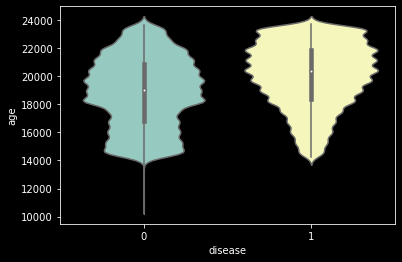

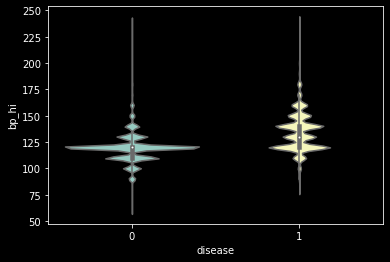

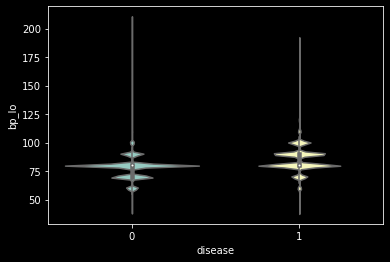

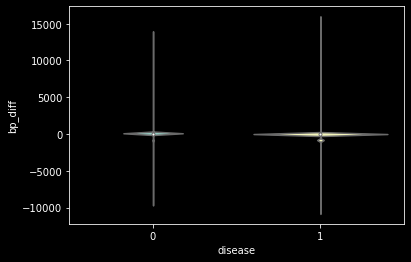

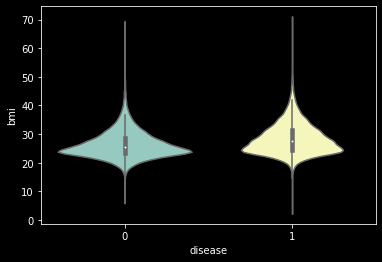

<IPython.core.display.Javascript object>

In [37]:
# df_sample = df.sample(frac=0.1, replace=True, random_state=28, axis="index")

for col in num_cols:
    sns.violinplot(x="disease", y=col, data=df)
    plt.show()

# Features

In [38]:
# blood pressure difference column
df["bp_diff"] = df.bp_hi - df.bp_lo

# BMI column to replace height and weight
# bmi = weight (kgs) / (height (m))^2
df["bmi"] = df.weight / (df.height / 100) ** 2

<IPython.core.display.Javascript object>

# Model Prep

> ### testing sets

In [39]:
drop_cols = [
    "disease",
    "yrs",
    "height_in",
    "height_ft",
    "bp_diff",
    #     "bmi",
    #         "height",
    #     "weight",
]

X = df.drop(columns=drop_cols)
y = df.disease

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=28, stratify=df.disease
)

<IPython.core.display.Javascript object>

In [40]:
bin_cols = ["gender", "smoke", "alcohol", "active"]
num_cols = ["age", "bp_hi", "bp_lo", "bp_diff", "bmi", "height", "weight"]
cat_cols = ["cholesterol", "glucose"]
# drop_cats = [0]

<IPython.core.display.Javascript object>

> ### preprocessing

In [41]:
preprocessing = ColumnTransformer(
    [
        ("encode_cats", LeaveOneOutEncoder(), cat_cols),
        #         ("scaler", StandardScaler(), num_cols),
        #         ("scaler", MinMaxScaler(), num_cols),
    ],
    remainder="passthrough",
)

<IPython.core.display.Javascript object>

# XGBoost Classifier

> ### pipeline

In [42]:
pipeline = Pipeline(
    [
        ("processing", preprocessing),
        #         ("model", GradientBoostingClassifier()),
        #         ("model", AdaBoostClassifier()),
        ("model", XGBClassifier(use_label_encoder=False)),
    ]
)

pipeline.fit(X_train, y_train)

train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"train score: {train_score}")
print(f"test score: {test_score}")

[13:27:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
train score: 0.7817115926202656
test score: 0.7273693890453474


<IPython.core.display.Javascript object>

# Grid Search CV

XGBoost

In [43]:
# fmt: off
grid = {
    "model__n_estimators": [1],
    "model__learning_rate": [10],
    #     "model__subsample": [],
    "model__colsample_bytree": [0.9],
    "model__max_depth": np.arange(1,10),
}
# fmt: on
pipeline_cv = GridSearchCV(pipeline, grid, cv=5, verbose=1, n_jobs=-1)
pipeline_cv.fit(X_train, y_train)

best_params = pipeline_cv.best_params_
best_params

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[13:27:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.8s finished


{'model__colsample_bytree': 0.9,
 'model__learning_rate': 10,
 'model__max_depth': 4,
 'model__n_estimators': 1}

<IPython.core.display.Javascript object>

In [44]:
train_score = pipeline_cv.score(X_train, y_train)
test_score = pipeline_cv.score(X_test, y_test)

print(f"train_score {train_score}")
print(f"test_score {test_score}")

train_score 0.7322834645669292
test_score 0.7276854991666187


<IPython.core.display.Javascript object>

In [45]:
feature_importances = pipeline_cv.best_estimator_["model"].feature_importances_
feature_importances = pd.DataFrame(
    {"feature": X_train.columns, "importance": feature_importances}
).sort_values("importance", ascending=False)
feature_importances

,feature,importance
6,cholesterol,0.826519
0,age,0.082505
2,height,0.076371
1,gender,0.008920
4,bp_hi,0.004443
11,bmi,0.001242
3,weight,0.000000
5,bp_lo,0.000000
7,glucose,0.000000
8,smoke,0.000000


<IPython.core.display.Javascript object>

# Prediction Results

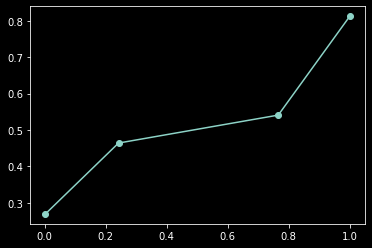

<IPython.core.display.Javascript object>

In [46]:
pred_prob = pipeline_cv.predict_proba(X_test)
# pred_prob

prob_true, prob_pred = calibration_curve(y_test, pred_prob[:, 1], n_bins=10)
plt.plot(prob_pred, prob_true, "-o")
plt.show()

In [47]:
y_preds = pipeline_cv.predict(X_test)
preds_df, fig = predictions_df(X_test, y_test, y_preds)

<IPython.core.display.Javascript object>

In [48]:
cm = confusion_matrix(y_test, y_preds)
cm

array([[12744,  4672],
       [ 4804, 12578]], dtype=int64)

<IPython.core.display.Javascript object>

In [49]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73     17416
           1       0.73      0.72      0.73     17382

    accuracy                           0.73     34798
   macro avg       0.73      0.73      0.73     34798
weighted avg       0.73      0.73      0.73     34798



<IPython.core.display.Javascript object>

# Error analysis

In [50]:
preds_df, fig = predictions_df(X_test, y_test, y_preds)
# display(preds_df[preds_df.residuals == -1].head(50))

mistakes = preds_df[preds_df.abs_residuals == 1]
correct = preds_df[preds_df.abs_residuals == 0]

# add prediction probs to preds_df
preds_df["pred_prob"] = pred_prob[:, 1]

preds_df = preds_df.drop(columns=["residuals", "abs_residuals"])

<IPython.core.display.Javascript object>

In [51]:
# dataframe for false negatives sorted by prediction probability descending
f_negs = preds_df[(preds_df.y_true == 1) & (preds_df.y_preds == 0)].sort_values(
    "pred_prob", ascending=False
)
f_negs.count()[0]

4804

<IPython.core.display.Javascript object>

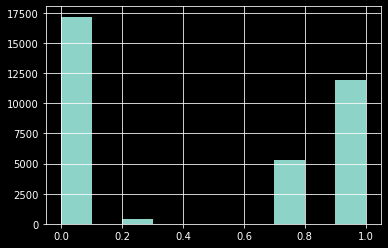

<IPython.core.display.Javascript object>

In [52]:
preds_df.pred_prob.hist()

# Support Vector Classifer

In [53]:
drop_cols = [
    "disease",
    "yrs",
    "height_in",
    "height_ft",
    #     "bp_diff",
    #     "bmi",
    #         "height",
    #     "weight",
]

X = df.drop(columns=drop_cols)
y = df.disease

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=28, stratify=df.disease
)

<IPython.core.display.Javascript object>

In [54]:
# fmt: off
pipeline = Pipeline(
    [
        ("processing", preprocessing),
        ("model", SVC())
    ]
)

<IPython.core.display.Javascript object>

In [ ]:
grid = {
    "model__kernel": ["rbf"],
    "model__gamma": [0.1],
    # "model__degree": [1,2,5],
    "model__C": np.arange(1,9,2),
}

model = GridSearchCV(pipeline, grid, verbose=1, cv=2, n_jobs=4)
model.fit(X_train, y_train)

best_params = model.best_params_
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"parameters: {best_params}")
print("=======================================")
print(f"train score: {train_score}")
print(f"test score: {test_score}")

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


## Prediction Results

In [ ]:
pred_prob = pipeline_cv.predict_proba(X_test)
# pred_prob

prob_true, prob_pred = calibration_curve(y_test, pred_prob[:, 1], n_bins=10)
plt.plot(prob_pred, prob_true, "-o")
plt.show()

In [ ]:
y_preds = pipeline_cv.predict(X_test)
preds_df, fig = predictions_df(X_test, y_test, y_preds)

In [ ]:
# confusion_matrix
cm = confusion_matrix(y_test, y_preds)
cm

In [ ]:
# classification report
print(classification_report(y_test, y_preds))

## Error analysis

In [ ]:
preds_df, fig = predictions_df(X_test, y_test, y_preds)
# display(preds_df[preds_df.residuals == -1].head(50))

mistakes = preds_df[preds_df.abs_residuals == 1]
correct = preds_df[preds_df.abs_residuals == 0]

# add prediction probs to preds_df
preds_df["pred_prob"] = pred_prob[:, 1]

preds_df = preds_df.drop(columns=["residuals", "abs_residuals"])

In [ ]:
# dataframe for false negatives sorted by prediction probability descending
f_negs = preds_df[(preds_df.y_true == 1) & (preds_df.y_preds == 0)].sort_values(
    "pred_prob", ascending=False
)
f_negs.count()[0]

In [ ]:
# histogram of prediction probability
preds_df.pred_prob.hist()